In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multiclassificationtask/sample_submission.csv
/kaggle/input/multiclassificationtask/train.csv
/kaggle/input/multiclassificationtask/test.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/multiclassificationtask/train.csv')  

print(train_data.head())  


   id  N_Days             Drug      Age Sex Ascites Hepatomegaly Spiders  \
0   0  2178.0  D-penicillamine  16374.0   F       N            N       N   
1   1  2644.0  D-penicillamine  17774.0   F       N            N       N   
2   2  3069.0          Placebo  17844.0   F       N            N       N   
3   3  2216.0          Placebo  19221.0   F       N            Y       Y   
4   4  2256.0          Placebo  21600.0   F       N            N       N   

  Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     N        0.5        263.0     3.20    43.0    1110.0  106.95   
1     N        0.8        280.0     3.60    22.0     678.0   62.00   
2     N        1.1        408.0     4.40    54.0    2108.0  142.60   
3     N        0.8        252.0     3.70    36.0     843.0   55.80   
4     N        4.7        348.0     3.06   464.0     961.0  120.90   

   Tryglicerides  Platelets  Prothrombin  Stage Status  
0           67.0      430.0          9.6    3.0      C  
1       

In [3]:
print("Train Data Info:")
print(train_data.info())  

print("\nTrain Data Description:")
print(train_data.describe())  

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8494 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 5   Ascites        8502 non-null   object 
 6   Hepatomegaly   8492 non-null   object 
 7   Spiders        8491 non-null   object 
 8   Edema          15000 non-null  object 
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6701 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8399 non-null   float64
 13  Alk_Phos       8488 non-null   float64
 14  SGOT           8486 non-null   float64
 15  Tryglicerides  6666 non-null   float64
 16  Platelets      14436 non-null  float64
 17  Prothrombin    14984 non-null  fl

In [4]:
print("\nTrain Data - Null Values Count:")
print(train_data.isnull().sum())  


Train Data - Null Values Count:
id                  0
N_Days              0
Drug             6506
Age                 0
Sex                 0
Ascites          6498
Hepatomegaly     6508
Spiders          6509
Edema               0
Bilirubin           0
Cholesterol      8299
Albumin             0
Copper           6601
Alk_Phos         6512
SGOT             6514
Tryglicerides    8334
Platelets         564
Prothrombin        16
Stage               0
Status              0
dtype: int64


In [5]:
null_percentage = (train_data.isnull().sum() / len(train_data)) * 100

print(null_percentage)

id                0.000000
N_Days            0.000000
Drug             43.373333
Age               0.000000
Sex               0.000000
Ascites          43.320000
Hepatomegaly     43.386667
Spiders          43.393333
Edema             0.000000
Bilirubin         0.000000
Cholesterol      55.326667
Albumin           0.000000
Copper           44.006667
Alk_Phos         43.413333
SGOT             43.426667
Tryglicerides    55.560000
Platelets         3.760000
Prothrombin       0.106667
Stage             0.000000
Status            0.000000
dtype: float64


In [6]:
print("\nTrain Data - Duplicated Rows:")
print(train_data.duplicated().sum()) 


Train Data - Duplicated Rows:
0


In [7]:
train_data = train_data.drop(columns=['Drug', 'Cholesterol', 'Tryglicerides', 'Ascites' , 'Hepatomegaly' , 'Spiders' , 'Copper' , 'Alk_Phos' , 'SGOT'])

numerical_cols = train_data.select_dtypes(include=['float64']).columns
train_data[numerical_cols] = train_data[numerical_cols].fillna(train_data[numerical_cols].median())

categorical_cols = train_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    
print(train_data.isnull().sum())


id             0
N_Days         0
Age            0
Sex            0
Edema          0
Bilirubin      0
Albumin        0
Platelets      0
Prothrombin    0
Stage          0
Status         0
dtype: int64


**Null qiymatlar bilan ishlash**

Dastlab, train to'plamidagi barcha ustunlarda null qiymatlarni tekshirib chiqdim. Bu orqali, ba'zi ustunlar, masalan, Drug, Cholesterol, va Tryglicerides kabi ustunlarda juda ko'p null qiymatlar borligini ko'rdim. Bu ustunlar model uchun juda ko'p yo'qotishlar keltirib chiqarishi mumkin, shuning uchun ularni olib tashlashga qaror qildim.

Keyin, numerik ustunlar bo'yicha null qiymatlarni to'ldirdim. Buning uchun har bir ustun uchun median qiymatini hisoblab chiqib, bu qiymat bilan null qiymatlarni to'ldirdim. 

Kategorik ustunlar uchun esa, null qiymatlarni eng ko'p uchraydigan qiymat, ya'ni mod bilan to'ldirdim. Bu usulda, har bir ustun bo'yicha eng ko'p uchragan qiymatni topdim va null qiymatlarni shu qiymat bilan almashtirdim.


Train Data - Status Value Counts:
Status
C     10053
D      4565
CL      381
Y         1
Name: count, dtype: int64


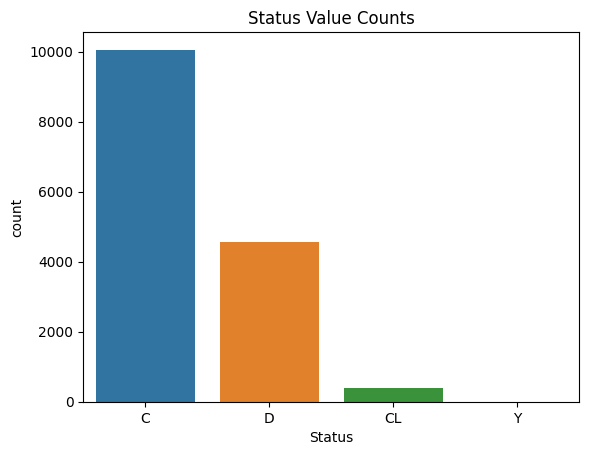

In [8]:
# Status kategoriyasidagi taqsimotni ko'rish
print("\nTrain Data - Status Value Counts:")
print(train_data['Status'].value_counts())  

sns.countplot(data=train_data, x='Status')
plt.title('Status Value Counts')
plt.show()


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           15000 non-null  int64  
 1   N_Days       15000 non-null  float64
 2   Age          15000 non-null  float64
 3   Sex          15000 non-null  object 
 4   Edema        15000 non-null  object 
 5   Bilirubin    15000 non-null  float64
 6   Albumin      15000 non-null  float64
 7   Platelets    15000 non-null  float64
 8   Prothrombin  15000 non-null  float64
 9   Stage        15000 non-null  float64
 10  Status       15000 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 1.3+ MB


In [10]:
print(train_data['Edema'].value_counts())
print(train_data['Status'].value_counts())
print(train_data['Sex'].value_counts())

Edema
N    13845
S      792
Y      363
Name: count, dtype: int64
Status
C     10053
D      4565
CL      381
Y         1
Name: count, dtype: int64
Sex
F    14392
M      608
Name: count, dtype: int64


In [11]:
print(train_data.columns)



Index(['id', 'N_Days', 'Age', 'Sex', 'Edema', 'Bilirubin', 'Albumin',
       'Platelets', 'Prothrombin', 'Stage', 'Status'],
      dtype='object')


In [12]:
train_data = pd.get_dummies(train_data, columns=['Sex', 'Edema'], drop_first=False)

le = LabelEncoder()


scaler = StandardScaler()

numerical_columns = ['N_Days', 'Age', 'Bilirubin', 'Albumin', 'Platelets', 'Prothrombin', 'Stage']

train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])

print(train_data.head())

   id    N_Days       Age  Bilirubin   Albumin  Platelets  Prothrombin  \
0   0  0.154668 -0.770163  -0.503009 -0.876018   1.921267    -1.403667   
1   1  0.504075 -0.401495  -0.390850  0.198512   1.888752     3.247483   
2   2  0.822740 -0.383061  -0.278691  2.347573  -0.539020    -0.035682   
3   3  0.183160 -0.020450  -0.390850  0.467145   0.902469    -1.403667   
4   4  0.213152  0.606022   1.067220 -1.252104   0.490615     0.511513   

      Stage Status  Sex_F  Sex_M  Edema_N  Edema_S  Edema_Y  
0 -0.028464      C   True  False     True    False    False  
1 -0.028464      C   True  False     True    False    False  
2 -0.028464      C   True  False     True    False    False  
3  1.119281      C   True  False     True    False    False  
4 -1.176209      D   True  False     True    False    False  


In [13]:
# Target va featuresni ajratish
X = train_data.drop(columns=['Status', 'id'])  # Status va idni ajratish
y = le.fit_transform(train_data['Status'])  # Statusni LabelEncoder orqali raqamlashtirish

# Train va validation setlarga bo‘lish
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape[0]} samples")
print(f"Validation size: {X_val.shape[0]} samples")

print("Statuslar va ularning raqamlari:", dict(zip(le.classes_, range(len(le.classes_)))))

Train size: 12000 samples
Validation size: 3000 samples
Statuslar va ularning raqamlari: {'C': 0, 'CL': 1, 'D': 2, 'Y': 3}
